In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, parallel_backend
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product

In [2]:
def clean_text(text):
    ''' 
    Some basic text cleaning phases this function should be applied to the text column
    of the data
    '''
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    stop = [w for w in stop if w not in ['not', 'no']]
    text = [x for x in text if (x not in stop)]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    # tokenize the text
    #text = text.split()
    return(text)
def apply_cleaning(X_train):
    '''
    With this fonction we apply the clean_text function to the text column of the data
    and it gives as output the cleaned data for each row of the text column
    '''
    X_train = X_train.apply(lambda x: clean_text(x))
    return(X_train)

def tfidf_featured_data(X_train):
    ''''
    No need to explain this function because we gonna use it in the pipeline automatically this function
    used to add tf-idfs columns to the data but I used this to play around with the data and see the
    results of the tfidf vectorizer
    '''

    X_train = apply_cleaning(X_train)
    # add tf-idfs columns
    tfidf = TfidfVectorizer(min_df = 30)
    tfidf_result = tfidf.fit_transform(X_train).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = X_train.index
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns = ['sentences'], inplace = True)
    
    return X_train

def dict2text(dicti):
    '''
    This function is used to convert the dictionary of parameters to a string
    used for GridsearchCV outputs to be saved in a csv file and to be used later 
    on project.
    '''
    text = ''
    for key, value in dicti.items():
        text += str(key) + '=' + str(value) + ' '
    return text

def format_params(params_str):
    '''
    I captured some differences between the parameters of the GridsearchCV output
    to standardize it and make it easy to be used later on the project.
    '''
    # Remove the opening and closing braces and quotes
    params_str = params_str.replace("{", "").replace("}", "").replace("'", "")

    # Replace commas with spaces
    params_str = params_str.replace(", ", " ")

    # Replace colons with equals signs
    params_str = params_str.replace(":", "=")

    # Remove spaces around equals signs
    params_str = params_str.replace("= ", "=").replace(" =", "=")

    return params_str

<AxesSubplot: xlabel='labels'>

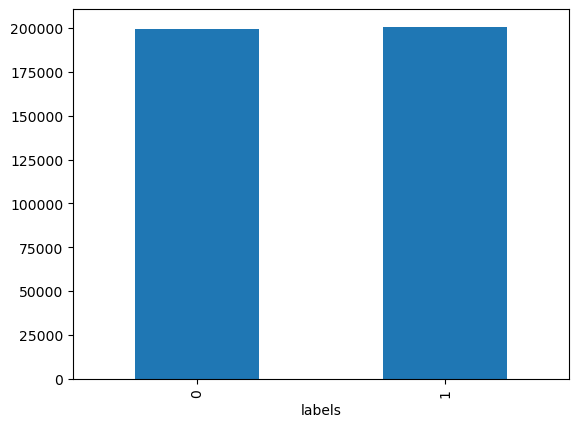

In [3]:
train = pd.read_csv('train_data_400k_randomsample.csv')
train["labels"].groupby(train["labels"]).count().plot(kind="bar")

In [7]:
# What this cell does is first subsampling the data to certain batches then doing hyperparameter tunning with GridsearchCV main reason for batching is that training all data 
# which is already huge gets more huge with tf-idf feature so the bigger the data it takes more time to train and tune the model so I decided to split the data into batches
# then taking the mean of each batch results to get the final results of the model. However slicing the data and taking the mean value of accuracy of all batches is good idea for
# generalization but when the sliced data is too small then hyperparameter setting for the small data is not good for the whole data so it is better to be careful about generalization. 

# Split the data into multiple slices

train["sentences"] = apply_cleaning(train["sentences"])

slices = [train[:100000], train[100000:200000], train[200000:300000], train[300000:400000]]

# Define the pipeline with normalization
pipeline_without_norm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

# Define the hyperparameters to tune for each pipeline
parameters_without_norm = {
    'tfidf__max_features': [5000],
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf']
}

dfs = []

for i, slice in enumerate(slices):
    print("Slice: ", i+1, str(len(slice)))
    # Split the current slice into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(slice["sentences"], slice["labels"], test_size=0.1)
    
    # Create a GridSearchCV object for each pipeline
    grid_search_without_norm = GridSearchCV(pipeline_without_norm, parameters_without_norm, cv=3, verbose=3)

    with parallel_backend(backend="multiprocessing", n_jobs=-1):
        # Fit the GridSearchCV object on the training data
        grid_search_without_norm.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = grid_search_without_norm.predict(X_test)

    # Calculate the accuracy score for the current slice
    score = accuracy_score(y_test, y_pred)

    # Print the accuracy score and best hyperparameters for the current slice
    print("Accuracy score: ", score)
    print("Best hyperparameters: ", grid_search_without_norm.best_params_)
    print("Best accuracy score: ", grid_search_without_norm.best_score_)

    #store it in a dataframe
    df = pd.DataFrame(list(zip(grid_search_without_norm.cv_results_['params'], grid_search_without_norm.cv_results_['mean_test_score'])), columns=['params', 'mean_test_score of batch '+str(i)])
    df.to_csv('grid_search_results20k_batch'+str(i)+'.csv')
    dfs.append(df)

dfs = pd.concat(dfs, axis=0, ignore_index=True)
dfs["params"] = dfs["params"].apply(lambda x: dict2text(x))
dfs = dfs.groupby(['params']).mean().to_csv('grid_search_results400k.csv')
pd.DataFrame(zip(dfs["params"].values,dfs.mean(axis=0)),columns=['params','mean_test_score']).sort_values(by='mean_test_score',ascending=False).to_csv('grid_search_results400k_no_rbfgamma_setting_.csv')

In [27]:
# What this cell does is first subsampling the data to certain batches then doing hyperparameter tunning with GridsearchCV main reason for batching is that training all data 
# which is already huge gets more huge with tf-idf feature so the bigger the data it takes more time to train and tune the model so I decided to split the data into batches
# then taking the mean of each batch results to get the final results of the model. However slicing the data and taking the mean value of accuracy of all batches is good idea for
# generalization but when the sliced data is too small then hyperparameter setting for the small data is not good for the whole data so it is better to be careful about generalization. 

# Split the data into multiple slices

# train["sentences"] = apply_cleaning(train["sentences"])

slices = [train[:100], train[100000:200000], train[200000:300000], train[300000:400000]]

# Define the pipeline with normalization
pipeline_without_norm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', LinearSVC())
])

duals = [True, False]
penaltys = ['l1', 'l2']
losses = ['hinge', 'squared_hinge']
all_params = list(product(duals, penaltys, losses))
filtered_params = [{'dual': [dual], 'penalty' : [penalty], 'loss': [loss]}
                   for dual, penalty, loss in all_params
                   if not (penalty == 'l1' and loss == 'hinge') 
                   and not ((penalty == 'l1' and loss == 'squared_hinge' and dual is True))
                  and not ((penalty == 'l2' and loss == 'hinge' and dual is False))]

# Define the hyperparameters to tune for each pipeline
c=[0.1, 1, 10]
duals = [True, False]
penaltys = ['l1', 'l2']
losses = ['hinge', 'squared_hinge']
all_params = list(product(duals, penaltys, losses,c))
filtered_params = [{'svc__dual': [dual], 'svc__penalty' : [penalty], 'svc__loss': [loss], 'svc__C':[C]}
                   for dual, penalty, loss, C in all_params
                   if not (penalty == 'l1' and loss == 'hinge') 
                   and not ((penalty == 'l1' and loss == 'squared_hinge' and dual is True))
                   and not ((penalty == 'l2' and loss == 'hinge' and dual is False))]

dfs = []

for i, slice in enumerate(slices):
    print("Slice: ", i+1, str(len(slice)))
    # Split the current slice into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(slice["sentences"], slice["labels"], test_size=0.1)
    
    # Create a GridSearchCV object for each pipeline
    grid_search = GridSearchCV(pipeline_without_norm, filtered_params, cv=3, verbose=3)

    with parallel_backend(backend="multiprocessing", n_jobs=-1):
        # Fit the GridSearchCV object on the training data
        grid_search.fit(X_train, y_train)

    # Predict the labels for the test set
    y_pred = grid_search.predict(X_test)

    # Calculate the accuracy score for the current slice
    score = accuracy_score(y_test, y_pred)

    # Print the accuracy score and best hyperparameters for the current slice
    print("Accuracy score: ", score)
    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best accuracy score: ", grid_search.best_score_)

    #store it in a dataframe
    df = pd.DataFrame(list(zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'])), columns=['params', 'mean_test_score of batch '+str(i)])
    df.to_csv('grid_search_results20k_batch'+str(i)+'.csv')
    dfs.append(df)

dfs = pd.concat(dfs, axis=0, ignore_index=True)
dfs["params"] = dfs["params"].apply(lambda x: dict2text(x))
dfs = dfs.groupby(['params']).mean().to_csv('grid_search_results400k.csv')
pd.DataFrame(zip(dfs["params"].values,dfs.mean(axis=0)),columns=['params','mean_test_score']).sort_values(by='mean_test_score',ascending=False).to_csv('grid_search_results400k_no_rbfgamma_setting_.csv')

Slice:  1 100
[CV 1/3] END svc__C=0.1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.633 total time=   0.0s[CV 2/3] END svc__C=1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.700 total time=   0.0s[CV 1/3] END svc__C=1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.633 total time=   0.0s[CV 2/3] END svc__C=0.1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.667 total time=   0.0s

[CV 3/3] END svc__C=0.1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.667 total time=   0.0s


[CV 3/3] END svc__C=1, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.700 total time=   0.0s[CV 2/3] END svc__C=10, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.767 total time=   0.0s[CV 1/3] END svc__C=10, svc__dual=True, svc__loss=hinge, svc__penalty=l2;, score=0.767 total time=   0.0s
[CV 2/3] END svc__C=0.1, svc__dual=True, svc__loss=squared_hinge, svc__penalty=l2;, score=0.667 total time=   0.0s
[CV 1/3] END svc__C=1, sv

KeyboardInterrupt: 

In [23]:
c=[0.1, 1, 10]
duals = [True, False]
penaltys = ['l1', 'l2']
losses = ['hinge', 'squared_hinge']
all_params = list(product(duals, penaltys, losses,c))
filtered_params = [{'svc__dual': [dual], 'svc__penalty' : [penalty], 'svc__loss': [loss], 'svc__C':[C]}
                   for dual, penalty, loss, C in all_params
                   if not (penalty == 'l1' and loss == 'hinge') 
                   and not ((penalty == 'l1' and loss == 'squared_hinge' and dual is True))
                   and not ((penalty == 'l2' and loss == 'hinge' and dual is False))]

filtered_params


[{'svc__dual': [True],
  'svc__penalty': ['l2'],
  'svc__loss': ['hinge'],
  'svc__C': [0.1]},
 {'svc__dual': [True],
  'svc__penalty': ['l2'],
  'svc__loss': ['hinge'],
  'svc__C': [1]},
 {'svc__dual': [True],
  'svc__penalty': ['l2'],
  'svc__loss': ['hinge'],
  'svc__C': [10]},
 {'svc__dual': [True],
  'svc__penalty': ['l2'],
  'svc__loss': ['squared_hinge'],
  'svc__C': [0.1]},
 {'svc__dual': [True],
  'svc__penalty': ['l2'],
  'svc__loss': ['squared_hinge'],
  'svc__C': [1]},
 {'svc__dual': [True],
  'svc__penalty': ['l2'],
  'svc__loss': ['squared_hinge'],
  'svc__C': [10]},
 {'svc__dual': [False],
  'svc__penalty': ['l1'],
  'svc__loss': ['squared_hinge'],
  'svc__C': [0.1]},
 {'svc__dual': [False],
  'svc__penalty': ['l1'],
  'svc__loss': ['squared_hinge'],
  'svc__C': [1]},
 {'svc__dual': [False],
  'svc__penalty': ['l1'],
  'svc__loss': ['squared_hinge'],
  'svc__C': [10]},
 {'svc__dual': [False],
  'svc__penalty': ['l2'],
  'svc__loss': ['squared_hinge'],
  'svc__C': [0.1]},

In [19]:
list(product(duals, penaltys, losses,c))

[(True, 'l1', 'hinge', 0.1),
 (True, 'l1', 'hinge', 1),
 (True, 'l1', 'hinge', 10),
 (True, 'l1', 'squared_hinge', 0.1),
 (True, 'l1', 'squared_hinge', 1),
 (True, 'l1', 'squared_hinge', 10),
 (True, 'l2', 'hinge', 0.1),
 (True, 'l2', 'hinge', 1),
 (True, 'l2', 'hinge', 10),
 (True, 'l2', 'squared_hinge', 0.1),
 (True, 'l2', 'squared_hinge', 1),
 (True, 'l2', 'squared_hinge', 10),
 (False, 'l1', 'hinge', 0.1),
 (False, 'l1', 'hinge', 1),
 (False, 'l1', 'hinge', 10),
 (False, 'l1', 'squared_hinge', 0.1),
 (False, 'l1', 'squared_hinge', 1),
 (False, 'l1', 'squared_hinge', 10),
 (False, 'l2', 'hinge', 0.1),
 (False, 'l2', 'hinge', 1),
 (False, 'l2', 'hinge', 10),
 (False, 'l2', 'squared_hinge', 0.1),
 (False, 'l2', 'squared_hinge', 1),
 (False, 'l2', 'squared_hinge', 10)]